# INTEGRACIÓN PARA CONSTRUCCIÓN DE UN GOLDEN DATASET CON API GPT-3.5 Turbo

In [1]:
import pandas as pd
import pathlib
import random
import os
import ast
import requests
import networkx as nx

from openai import OpenAI
from dotenv import load_dotenv
from collections import defaultdict

#pip install --upgrade openai==1.1.1
#pip install cohere tiktoken
#!pip3 install python-dotenv

#print(openai.__version__)

In [6]:
ruta_archivo = '/export/usuarios_ml4ds/cggamella/RAG_tool/dataset_pruebas.xlsx'
# Utiliza la función to_excel para exportar el DataFrame a un archivo Excel
df = pd.read_excel(ruta_archivo)

In [7]:
df

,acronyms,expanded_acronyms,text,detected_acronyms,LLM_expanded_acronyms
0,ONG,ONG,Las ONG son organizaciones no gubernamentales ...,NaN,NaN
1,"CIA, FBI","CIA, FBI",La CIA y el FBI colaboran en investigaciones i...,NaN,NaN
2,"UE, OTAN","UE, OTAN",La unión europea y la OTAN tienen roles crucia...,NaN,NaN
3,NASA,NASA,"La NASA es la agencia espacial estadounidense,...",NaN,NaN
4,UNICEF,UNICEF,"UNICEF, trabajan por los derechos de los niños...",NaN,NaN
...,...,...,...,...,...
63,FAQ,FAQ,La sección de preguntas frecuentes FAQ proporc...,NaN,NaN
64,CEO,CEO,El CEO de la compañía anunció planes de expans...,NaN,NaN
65,CFO,CFO,El chief financial officer presentó el informe...,NaN,NaN
66,CTO,CTO,El CTO lidera el equipo de desarrollo tecnológ...,NaN,NaN


## Integración para acronyms con DSPY

In [1]:
#!pip list
#!pip install --upgrade pydantic
#!pip install --upgrade openai
#!pip install git+https://github.com/stanfordnlp/dspy.git

In [2]:
from typing import List, Union
import matplotlib.pyplot as plt
import pathlib
import pandas as pd
import numpy as np
import pickle
import chromadb
import random
import os
import re
from langchain.embeddings import HuggingFaceEmbeddings 

import dspy
from dotenv import load_dotenv

from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

In [3]:
###########
#   LLM   #
###########
path_env = pathlib.Path("/export/usuarios_ml4ds/cggamella/NP-Search-Tool/.env")
print(path_env)
load_dotenv(path_env)
api_key = os.getenv("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = api_key

path_env = pathlib.Path("/export/usuarios_ml4ds/cggamella/NP-Search-Tool/.env")
print(path_env)
load_dotenv(path_env)
api_key = os.getenv("HUGGINGFACE_API_KEY")
os.environ["HUGGINGFACE_API_KEY"] = api_key

lm = dspy.HFClientTGI(model="meta-llama/Meta-Llama-3-8B", port=8080, url="http://127.0.0.1")
#lm = dspy.OpenAI(model="gpt-4o-mini")# "gpt-4o-2024-05-13")

dspy.settings.configure(lm=lm, temperature = 0)

/export/usuarios_ml4ds/cggamella/NP-Search-Tool/.env
/export/usuarios_ml4ds/cggamella/NP-Search-Tool/.env


### Just checking that DSPY with LLAMA works

In [190]:
'''
qa = dspy.ChainOfThought('question -> answer')

# Run with Llama instead
with dspy.context(lm=lm):
    response = qa(question="What is the first day of the week?")
    print('Model:', response.answer)
'''

Model: Sunday


### Synthetic acronymn generation

In [195]:
# Cargar dataframe donde se guardará la información 
ruta_archivo = '/export/usuarios_ml4ds/cggamella/RAG_tool/files/syntetic_for_graphs.xlsx'
df = pd.read_excel(ruta_archivo)
df.head(4)

,acronyms,manual_expanded,text
0,pdf,portable document format,NaN
1,pdf,probabilistic density function,NaN
2,tcp,transmission control protocol,NaN
3,tcp,tasa de crecimiento de producto,NaN


In [196]:
# Te he modificado esto un poco. Si haces las instrucciones en inglés, las definiciones del input y del output también deberían estar en inglés.
# Ten en cuenta que la signature es tu prompt, simplemente la estás definiendo como una clase
class AcronymGenerator(dspy.Signature):
    """
    Genera un texto en ESPAÑOL que contenga ACRONIMOS dentro de un contexto realista. 
    
    ACRONIMOS: (('IVA', 'impuesto valor añadido'))
    TEXTO_GENERADO: La reforma del sistema tributario ha traído cambios significativos en el IVA,
    afectando tanto a consumidores como a empresarios. Las PYME han mostrado preocupación por el aumento
    de la carga fiscal, ya que sus márgenes de beneficio son más ajustados.
    """
    
    ACRONIMOS = dspy.InputField(desc="Tupla de acrónimos con sus significados. Un acrónimo, es un tipo de palabra acuñada deliberadamente a partir de la fusión de varias otras palabras")
    TEXTO_GENERADO = dspy.OutputField(desc="Ejemplo de texto en español que incorpora el acrónimo o su forma expandida en un contexto realista posible basándose en el significado del acrónimo y elaborando un texto sobre ese tema.")
    
class AcronymGeneratorModule(dspy.Module):
    def __init__(self):
        super().__init__()
        self.generator = dspy.Predict(AcronymGenerator)

    def forward(self, acronyms):  
        response = self.generator(ACRONIMOS=acronyms)    
        return dspy.Prediction(TEXTO_GENERADO=response.TEXTO_GENERADO)

In [197]:
df

,acronyms,manual_expanded,text
0,pdf,portable document format,NaN
1,pdf,probabilistic density function,NaN
2,tcp,transmission control protocol,NaN
3,tcp,tasa de crecimiento de producto,NaN
4,cd,compact disc,NaN
5,cd,certificado de depósito,NaN
6,API,interfaz de programación de aplicaciones,NaN
7,API,american petrol institute,NaN
8,B2B,business to business,NaN
9,B2B,born to be,NaN


In [198]:
lista_acronyms = df['acronyms'].str.lower().tolist()
lista_expanded_acronyms = df['manual_expanded'].str.lower().tolist()
# Crear una lista de tuplas con acrónimos y sus formas expandidas
acronym_pairs= tuple(zip(lista_acronyms, lista_expanded_acronyms))

In [33]:
lista_acronyms[0:3]

['pdf', 'pdf', 'tcp']

In [200]:
acronym_pairs

(('pdf', 'portable document format'),
 ('pdf', 'probabilistic density function'),
 ('tcp', 'transmission control protocol'),
 ('tcp', 'tasa de crecimiento de producto'),
 ('cd', 'compact disc'),
 ('cd', 'certificado de depósito'),
 ('api', 'interfaz de programación de aplicaciones'),
 ('api', 'american petrol institute'),
 ('b2b', 'business to business'),
 ('b2b', 'born to be'),
 ('ocr', 'optical character recognition'),
 ('ocr', 'comité olímpico ruso'),
 ('uv', 'radiación ultravioleta'),
 ('uv', 'unidad de vigilancia'),
 ('uv', 'universidad virtual'),
 ('atp', 'asociación de tenistas profesionales'),
 ('atp', 'adenosín trifosfato'),
 ('atp', 'autorización de transporte público'),
 ('pvc', 'cloruro de polivinilo'),
 ('pvc', 'valor presente contable '),
 ('pvc', 'punto de venta al consumidor'),
 ('tac', 'tomografía axial computarizada '),
 ('tac', 'tasa anual compuesta'))

In [10]:
acronyms = []

# Iterar sobre la lista de tuplas
for pair in acronym_pairs:
    # Para seleccionar aleatoriamente entre acrónimo o forma expandida
    selected = random.choice(pair)
    acronyms.append(selected)

# Lista con los elegidos
print(acronyms)

['portable document format', 'probabilistic density function', 'transmission control protocol', 'tasa de crecimiento de producto', 'compact disc', 'cd', 'api', 'api', 'b2b', 'born to be', 'ocr', 'ocr', 'radiación ultravioleta', 'unidad de vigilancia', 'universidad virtual', 'asociación de tenistas profesionales', 'atp', 'autorización de transporte público', 'cloruro de polivinilo', 'valor presente contable ', 'punto de venta al consumidor', 'tac', 'tasa anual compuesta']


In [218]:
acronym_copy = acronym_pairs[3:5]

In [224]:
acronym_copy

(('tcp', 'tasa de crecimiento de producto'), ('cd', 'compact disc'))

In [205]:
df_new

,acronyms,manual_expanded,text
0,pdf,portable document format,La empresa de tecnología ha lanzado una aplica...
1,pdf,portable document format,El formato de archivo pdf ha sido ampliamente ...
2,pdf,probabilistic density function,La empresa de tecnología ha lanzado una aplica...
3,pdf,probabilistic density function,La empresa de tecnología ha lanzado una aplica...
4,tcp,transmission control protocol,El protocolo de transferencia de control (TCP)...
5,tcp,transmission control protocol,La tecnología de comunicación por paquetes (TC...


In [ ]:
# Paso 1: Eliminar duplicados en 'text'
df = df.drop_duplicates(subset='text', keep='first')

# Paso 2: Estadísticas sobre 'manual_expanded'
manual_expanded_stats = df['manual_expanded'].value_counts()

# Imprimir el DataFrame sin duplicados para verificación
print("DataFrame después de eliminar duplicados:")
print(df)

# Imprimir las estadísticas de 'manual_expanded'
print("\nEstadísticas de 'manual_expanded':")
print(manual_expanded_stats)

In [42]:
df['text'][0]

'En la actualidad, el uso del PDF se ha vuelto indispensable en el ámbito empresarial y académico. Por ejemplo, muchas universidades optan por enviar las guías de estudio y los trabajos finales en formato PDF, ya que este tipo de archivo garantiza que el contenido se mantenga intacto, independientemente del dispositivo o sistema operativo utilizado. Además, las empresas utilizan el PDF para compartir contratos y documentos importantes, asegurando que la información no se altere durante el proceso de envío. La posibilidad de incluir firmas digitales en los archivos PDF también ha facilitado la formalización de acuerdos sin necesidad de imprimir documentos, lo que contribuye a la sostenibilidad. Sin'

[[-0.06679891 -0.48117295 -0.19756965 ... -0.21475467  0.29681745
   0.36869365]
 [-0.37443516 -0.48146412 -0.12419088 ...  0.05084684  0.25897694
   0.19495529]
 [-0.14690958 -0.1638864  -0.5375875  ... -0.13538334  0.70971483
   0.2878126 ]
 ...
 [-0.3769554  -0.22730024 -0.05819358 ...  0.2584874   0.2725061
   0.08829246]
 [-0.20389251 -0.19332562 -0.03974314 ...  0.01789336  0.13603465
  -0.03029177]
 [-0.25283217 -0.30701444 -0.20147121 ... -0.28607848  0.00418233
  -0.02199554]]
La matriz de similitud es:
 [[1.0000002  0.63302255 0.6740758  ... 0.5710942  0.52382845 0.37483284]
 [0.63302255 0.9999999  0.6161341  ... 0.46457115 0.48841187 0.3524871 ]
 [0.6740758  0.6161341  0.9999999  ... 0.47808206 0.4707216  0.35096297]
 ...
 [0.5710942  0.46457115 0.47808206 ... 0.9999999  0.62260467 0.5171031 ]
 [0.52382845 0.48841187 0.4707216  ... 0.62260467 1.0000004  0.52558064]
 [0.37483284 0.3524871  0.35096297 ... 0.5171031  0.52558064 1.0000002 ]]


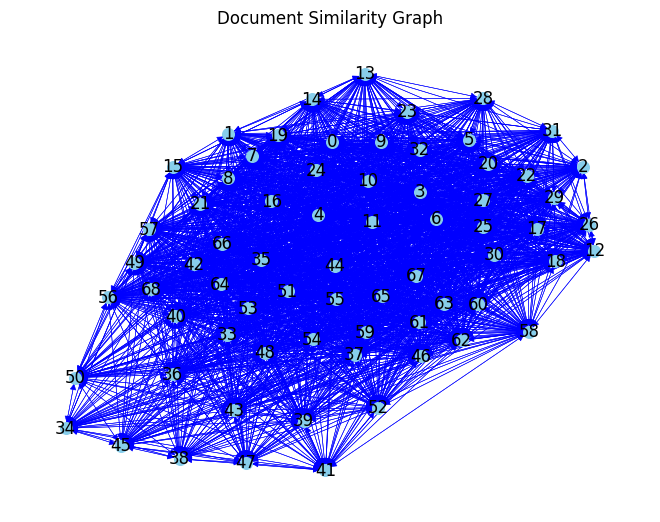

In [77]:
from src.utils.vector_store_utils import CustomEmbeddings

# Instancia de CustomEmbeddings
custom_embeddings = CustomEmbeddings()

# Suponiendo que df['text'] contiene los textos de los documentos
embeddings = custom_embeddings(df['text'].tolist())

# Instancia de GraphVisualizer
graph_visualizer = GraphVisualizer()

# Establecer embeddings en el visualizador
graph_visualizer.set_embeddings(embeddings)

# Visualizar el grafo
graph_stats = graph_visualizer.visualize_graph()

In [ ]:
from sklearn.cluster import KMeans

# Número de clusters esperados
n_clusters = 3

# Ejecutar K-means
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(embeddings)

# Puedes explorar los resultados
df['cluster'] = clusters
print(df[['text', 'cluster']])

In [ ]:
from sklearn.cluster import SpectralClustering

# Definir el número de clusters
n_clusters = 5

# Aplicar Spectral Clustering
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
clusters = spectral.fit_predict(embeddings)

# Ver los resultados
df['cluster'] = clusters
print(df[['text', 'cluster']])

In [ ]:
!pip install torch_geometric

# Zero-shot HF

In [28]:
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings, ast, os, torch, time, re

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from transformers import MPNetTokenizer, MPNetModel
from transformers import AutoTokenizer, AutoModel
from transformers import AutoModelForSequenceClassification
from transformers import pipeline

In [91]:
df = pd.read_excel('/export/usuarios_ml4ds/cggamella/RAG_tool/files/syntetic_for_graphs_copy.xlsx')

In [92]:
df

,acronyms,manual_expanded,text,tag
0,pdf,portable document format,El formato PDF es uno de los más utilizados pa...,1
1,pdf,portable document format,"Para crear un archivo PDF, puedes utilizar her...",1
2,pdf,portable document format,El formato PDF permite proteger la integridad ...,1
3,pdf,portable document format,Los archivos PDF son ideales para compartir do...,1
4,pdf,portable document format,El formato PDF es ampliamente utilizado en el ...,1
...,...,...,...,...
64,pdf,probabilistic density function,La PDF se puede utilizar para analizar datos d...,2
65,pdf,probabilistic density function,La PDF se puede utilizar para describir la dis...,2
66,pdf,probabilistic density function,La PDF se utiliza en el procesamiento de señal...,2
67,pdf,probabilistic density function,La PDF se puede utilizar en la teoría de la in...,2


In [6]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [11]:
# Verifica si PyTorch tiene acceso a una GPU
if torch.cuda.is_available():
    print(f'GPU disponible: {torch.cuda.get_device_name(0)}')
    # Establece la GPU como dispositivo por defecto
    device = 0  # GPU
else:
    print("No se encontró GPU. Usando CPU en su lugar.")
    device = -1  # CPU

GPU disponible: NVIDIA GeForce RTX 4090


In [39]:
#La evaluación del creador sobre su test consigue en español: 0.845
model_st = "MoritzLaurer/mDeBERTa-v3-base-mnli-xnli"
#model_st = "facebook/bart-large-mnli"
tokenizer = AutoTokenizer.from_pretrained(model_st)
model = AutoModelForSequenceClassification.from_pretrained(model_st)

In [40]:
categories = set(df['manual_expanded'])
lista_categorias = [x.lower() for x in categories]

In [41]:
def calcular_precision_por_categoria(df, categories):
    # Inicializar contadores por categoría
    contador_categorias = {categoria: {'aciertos': 0, 'total': 0, 'no_clasificados': 0} for categoria in categories}
    
    for _, fila in df.iterrows():
        texto = fila['text']
        print("El texto a clasificar es:\n", texto)
        categoria_real = fila['manual_expanded']
        print("La categoria real es:", categoria_real)
        
        # Clasificar la query
        resultado = classifier(texto, candidate_labels=categories, device=device, multi_label=True)
        
        # Verificar la independencia de las etiquetas
        etiquetas_por_encima_04 = [score for score in resultado['scores'] if score > 0.3]
        if len(etiquetas_por_encima_04) > 1:
            # Si más de una etiqueta tiene un valor por encima de 0.4, se considera no clasificada
            print("La fila no se ha podido clasificar debido a baja independencia de etiquetas.")
            contador_categorias[categoria_real]['no_clasificados'] += 1
            continue
        
        # Obtener la categoría predicha
        categoria_predicha = resultado['labels'][0]
        print("La categoria predicha es:", categoria_predicha)
        
        # Actualizar contadores
        contador_categorias[categoria_real]['total'] += 1
        if categoria_predicha == categoria_real:
            contador_categorias[categoria_real]['aciertos'] += 1
    
    # Calcular la precisión por categoría
    precisiones_por_categoria = {}
    no_clasificados_por_categoria = {}
    for categoria, contador in contador_categorias.items():
        if contador['total'] > 0:  # Evitar división por cero
            precision = (contador['aciertos'] / contador['total']) * 100
        else:
            precision = 0  # En caso de que no haya instancias de una categoría
        precisiones_por_categoria[categoria] = precision
        no_clasificados_por_categoria[categoria] = contador['no_clasificados']
    
    return precisiones_por_categoria, no_clasificados_por_categoria

In [42]:
# Inicializar el tiempo de inicio
start_time_gpu = time.time()

precisiones, no_clasificados = calcular_precision_por_categoria(df, lista_categorias)
for categoria, precision in precisiones.items():
    print(f'La precisión para la categoría {categoria} es: {precision:.2f}%')
for categoria, no_clasificado in no_clasificados.items():
    print(f'El número de filas no clasificadas para la categoría {categoria} es: {no_clasificado}')


# Calcular el tiempo de ejecución
end_time_gpu = time.time()

print(f"Tiempo de ejecución usando GPU: {end_time_gpu - start_time_gpu}")

El texto a clasificar es:
 El formato PDF es uno de los más utilizados para compartir documentos en línea debido a su compatibilidad con diferentes sistemas operativos y dispositivos.
La categoria real es: formato de documento portable
La fila no se ha podido clasificar debido a baja independencia de etiquetas.
El texto a clasificar es:
 Para crear un archivo PDF, puedes utilizar herramientas gratuitas como Adobe Acrobat o convertidores en línea.
La categoria real es: formato de documento portable
La categoria predicha es: formato de documento portable
El texto a clasificar es:
 El formato PDF permite proteger la integridad del contenido del documento, evitando que se modifique sin autorización.
La categoria real es: formato de documento portable
La categoria predicha es: formato de documento portable
El texto a clasificar es:
 Los archivos PDF son ideales para compartir documentos que contengan imágenes, gráficos o diseños complejos, ya que mantienen su formato original.
La categoria 

La categoria predicha es: formato de documento portable
El texto a clasificar es:
 El formato PDF es compatible con diferentes idiomas y sistemas de escritura, lo que lo hace ideal para documentos internacionales.
La categoria real es: formato de documento portable
La fila no se ha podido clasificar debido a baja independencia de etiquetas.
El texto a clasificar es:
 Los archivos PDF pueden ser indexados por motores de búsqueda, lo que facilita su localización y recuperación en línea.
La categoria real es: formato de documento portable
La fila no se ha podido clasificar debido a baja independencia de etiquetas.
El texto a clasificar es:
 La función de densidad de probabilidad (PDF) es una herramienta estadística utilizada para describir la distribución de probabilidad de una variable aleatoria continua.
La categoria real es: función de densidad de probabilidad
La fila no se ha podido clasificar debido a baja independencia de etiquetas.
El texto a clasificar es:
 La función de densidad 

La categoria predicha es: formato de documento portable
El texto a clasificar es:
 La PDF se puede utilizar para describir la distribución de errores en modelos estadísticos.
La categoria real es: función de densidad de probabilidad
La categoria predicha es: formato de documento portable
El texto a clasificar es:
 La PDF se puede utilizar para evaluar la precisión de estimaciones estadísticas.
La categoria real es: función de densidad de probabilidad
La categoria predicha es: formato de documento portable
El texto a clasificar es:
 La PDF se puede utilizar para diseñar experimentos y determinar el tamaño de la muestra necesario para obtener resultados significativos.
La categoria real es: función de densidad de probabilidad
La fila no se ha podido clasificar debido a baja independencia de etiquetas.
El texto a clasificar es:
 La PDF se puede utilizar para analizar datos de series temporales y predecir tendencias futuras.
La categoria real es: función de densidad de probabilidad
La cate

# Modelos de transformers para clasificar

In [39]:
# Carga el modelo
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')

In [40]:
embeddings_categorias = model.encode(lista_categorias)
print("Las dimensiones de los embeddings de categorias son:\n", embeddings_categorias.shape)
print("Los embeddings de categorias son:\n", embeddings_categorias)

NameError: name 'lista_categorias' is not defined

In [94]:
lista_categorias

['probabilistic density function', 'portable document format']

In [95]:
def clasificar_consulta(query, embeddings_categorias, categorias):
    """
    Descripción: Clasifica la consulta utilizando 1-NN basado en la similitud del coseno.
    
    Parámetros:
    - query: Cadena de texto introducida por el usuario.
    - embeddings_categorias: Son los embeddings de las categorías precalculados.
    - categorias: Es la lista de categorías en orden alfabético.
    """
    # Calcular embedding de query
    embedding_query = model.encode([query])
    embeddings_usados = embeddings_categorias
    lista_usada = categorias
    
    # Calcular la similitud del coseno entre el embedding de la consulta y los embeddings seleccionados
    similitudes = cosine_similarity(embedding_query, embeddings_usados)[0]
    
    # Ordenar similitudes y encontrar las dos mayores
    sorted_indices = np.argsort(similitudes)[::-1]
    max_sim = similitudes[sorted_indices[0]]
    print("El valor max_sim es", max_sim)
    second_max_sim = similitudes[sorted_indices[1]]
    print("El valor second_max_sim es", second_max_sim)

    # Verificar la regla de diferencia de similitud
    if abs(max_sim - second_max_sim) < 0.25:
        print("La diferencia entre similitudes es menor a 0.25, marcar como PENDIENTE.")
        return "PENDIENTE", similitudes
    
    # Seleccionar la categoría correspondiente
    prediccion = lista_usada[sorted_indices[0]]
    print(f"La categoría predicha es: {prediccion}")
    print(f"Similitudes: {similitudes}")
    
    return prediccion, similitudes

In [96]:
def evaluar_modelo(df, embeddings_categorias, lista_categorias):
    aciertos_categorias = 0
    pendientes = 0
    
    for _, row in df.iterrows():
        query = row['text']
        print("La query es:", query)
        
        # Clasificar categoría
        categoria_predicha, similitudes = clasificar_consulta(query, embeddings_categorias, lista_categorias)
        print("La categoría predicha es:", categoria_predicha)
        
        # Mostrar la categoría real
        categoria_real = row['manual_expanded']
        print("La categoría real es:", categoria_real)
        print("Similitudes:", similitudes)
        
        if categoria_predicha == "PENDIENTE":
            pendientes += 1
            continue
        
        if categoria_real in categoria_predicha:
            aciertos_categorias += 1
        
    total_predicciones = len(df) 
    
    # Calcular la precisión global para categorías
    precision_categorias = aciertos_categorias / (total_predicciones - pendientes) if (total_predicciones - pendientes) > 0 else 0

    print("Evaluación Global para Categorías:")
    print(f"Precisión: {precision_categorias:.4f} ({aciertos_categorias}/{total_predicciones - pendientes} aciertos)")
    print(f"Número de pendientes: {pendientes} de {total_predicciones} filas")

In [97]:
start_time_gpu = time.time()
# Ejemplo de uso
evaluar_modelo(df, embeddings_categorias,lista_categorias)
# Calcular el tiempo de ejecución
end_time_gpu = time.time()
print(f"Tiempo de ejecución usando GPU: {end_time_gpu - start_time_gpu}")

La query es: El formato PDF es uno de los más utilizados para compartir documentos en línea debido a su compatibilidad con diferentes sistemas operativos y dispositivos.
El valor max_sim es 0.6829367
El valor second_max_sim es 0.057088602
La categoría predicha es: portable document format
Similitudes: [0.0570886 0.6829367]
La categoría predicha es: portable document format
La categoría real es: portable document format
Similitudes: [0.0570886 0.6829367]
La query es: Para crear un archivo PDF, puedes utilizar herramientas gratuitas como Adobe Acrobat o convertidores en línea.
El valor max_sim es 0.602937
El valor second_max_sim es 0.04991404
La categoría predicha es: portable document format
Similitudes: [0.04991404 0.602937  ]
La categoría predicha es: portable document format
La categoría real es: portable document format
Similitudes: [0.04991404 0.602937  ]
La query es: El formato PDF permite proteger la integridad del contenido del documento, evitando que se modifique sin autorizaci

El valor max_sim es 0.5001603
El valor second_max_sim es 0.012421341
La categoría predicha es: portable document format
Similitudes: [0.01242134 0.5001603 ]
La categoría predicha es: portable document format
La categoría real es: portable document format
Similitudes: [0.01242134 0.5001603 ]
La query es: El formato PDF permite agregar firmas digitales a los documentos, lo que garantiza su autenticidad y validez legal.
El valor max_sim es 0.51628023
El valor second_max_sim es 0.10523585
La categoría predicha es: portable document format
Similitudes: [0.10523585 0.51628023]
La categoría predicha es: portable document format
La categoría real es: portable document format
Similitudes: [0.10523585 0.51628023]
La query es: Los archivos PDF pueden ser optimizados para su visualización en dispositivos móviles, lo que facilita su lectura en pantallas pequeñas.
El valor max_sim es 0.663716
El valor second_max_sim es -0.002611778
La categoría predicha es: portable document format
Similitudes: [-0.

El valor max_sim es 0.40798628
El valor second_max_sim es 0.2187057
La diferencia entre similitudes es menor a 0.25, marcar como PENDIENTE.
La categoría predicha es: PENDIENTE
La categoría real es: probabilistic density function
Similitudes: [0.40798628 0.2187057 ]
La query es: La PDF se puede utilizar para evaluar la precisión de estimaciones estadísticas.
El valor max_sim es 0.36307582
El valor second_max_sim es 0.2912557
La diferencia entre similitudes es menor a 0.25, marcar como PENDIENTE.
La categoría predicha es: PENDIENTE
La categoría real es: probabilistic density function
Similitudes: [0.36307582 0.2912557 ]
La query es: La PDF se puede utilizar para diseñar experimentos y determinar el tamaño de la muestra necesario para obtener resultados significativos.
El valor max_sim es 0.38382027
El valor second_max_sim es 0.23509088
La diferencia entre similitudes es menor a 0.25, marcar como PENDIENTE.
La categoría predicha es: PENDIENTE
La categoría real es: probabilistic density fu

# REGRESIÓN LOGÍSTICA

In [32]:
#df = pd.read_excel('/export/usuarios_ml4ds/cggamella/RAG_tool/files/syntetic_for_graphs_copy.xlsx')
df = pd.read_excel('/export/usuarios_ml4ds/cggamella/RAG_tool/files/syntetic_for_graphs.xlsx')

In [33]:
df

,acronyms,manual_expanded,text
0,pdf,portable document format,El formato PDF es ampliamente utilizado en el ...
1,pdf,portable document format,La creación de documentos en PDF se ha vuelto ...
2,pdf,portable document format,"Además, el PDF ofrece características de segur..."
3,pdf,portable document format,"Por otro lado, la posibilidad de agregar hiper..."
4,pdf,portable document format,"Finalmente, la popularidad del formato PDF no ..."
...,...,...,...
134,tac,tasa anual compuesta,La Tasa Anual Compuesta (TAC) es un concepto f...
135,tac,tasa anual compuesta,"Cuando se habla de TAC, es importante consider..."
136,tac,tasa anual compuesta,La fórmula para calcular la TAC es bastante si...
137,tac,tasa anual compuesta,"Al comparar diferentes productos financieros, ..."


In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

# Carga el modelo
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')

# Dividir el conjunto de datos en entrenamiento y test
df_train, df_test = train_test_split(df, test_size=0.5, random_state=42, stratify=df['manual_expanded'])

# Obtener los embeddings para entrenamiento y test
embeddings_df_train = model.encode(df_train['text'].tolist())
embeddings_df_test = model.encode(df_test['text'].tolist())

# Codificar las categorías
label_encoder = LabelEncoder()
labels_train = label_encoder.fit_transform(df_train['manual_expanded'])
print("Labels train",labels_train)
labels_test = label_encoder.transform(df_test['manual_expanded'])
print("Labels test",labels_test)

# Entrenar el modelo de regresión logística
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(embeddings_df_train, labels_train)

Labels train [ 7 12 17  2 18  4 10 21  5 19 15 20 11  9 16  5 19 10  3  6 12  3  1  6
  7 20  3  0  8  6  5 16  2 13 14 11  8 15 22 22  8  1 14 17  9  3 13 18
 15  4  2  8 12 19 18  7  1 21  0  4 14 22 21  0 10 13 11 20  7]
Labels test [ 9 10 20 17 20 13  4  3  3 11  7  4 13  5  2 16  8  2  6 10 22 11  6 20
  8 14  2 14  9  4 15  7 12  1 22 18  3  1 12  2 15  8 16  5  0 10 22 18
  7  8 21 22 18  5 19 11 21  1  0 11  3 21 19 16 20 17  9 19  7 13]


LogisticRegression(max_iter=1000)

In [36]:
def clasificar_consulta(query, logistic_model, label_encoder):
    """
    Descripción: Clasifica la consulta con regresión logística.
    
    Parámetros:
    - query: texto a clasificar
    - logistic_model: modelo de regresión logística entrenado
    - label_encoder: codificador de etiquetas
    """
    # Calcular embedding de query
    embedding_query = model.encode([query])
    # Predecir probabilidades
    prob = logistic_model.predict_proba(embedding_query)[0]
    print("Las prob son:", prob)
    # Ordenar probabilidades y encontrar la mayor
    sorted_indices = np.argsort(prob)[::-1]
    # Seleccionar la categoría correspondiente
    prediccion = label_encoder.inverse_transform([sorted_indices[0]])[0]

    return prediccion, prob

In [37]:
def evaluar_modelo(df, logistic_model, label_encoder):
    y_true = []
    y_pred = []
    
    for _, row in df.iterrows():
        query = row['text']
        print("La query es:", query)
        
        # Clasificar categoría
        categoria_predicha, prob = clasificar_consulta(query, logistic_model, label_encoder)
        print("La categoría predicha es:", categoria_predicha)
        
        # Mostrar la categoría real
        categoria_real = row['manual_expanded']
        print("La categoría real es:", categoria_real)
        print("Probabilidades:", prob)
        
        y_true.append(categoria_real)
        y_pred.append(categoria_predicha)
      
    # Calcular y mostrar el informe de clasificación
    report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
    print("Evaluación Global para Categorías:")
    print(report)

In [38]:
# Evaluar el modelo en el conjunto de validación
evaluar_modelo(df_test, logistic_model, label_encoder)

La query es: A pesar del auge de la música digital y el streaming, el CD sigue teniendo un lugar en el corazón de muchos aficionados a la música. Las ediciones especiales, los álbumes en vivo y las versiones de lujo son solo algunas de las razones por las que los amantes de la música continúan comprando CD. Además, el acto de sostener un disco físico y leer las notas del álbum es una experiencia que no se puede replicar en el mundo digital.
Las prob son: [0.01752821 0.0183304  0.02324006 0.01778337 0.04048163 0.02990706
 0.09444658 0.03470919 0.01625869 0.3142234  0.01860021 0.02880581
 0.05116549 0.03164587 0.04985575 0.02733902 0.01364263 0.02377886
 0.0426271  0.02046753 0.01956754 0.0443876  0.02120801]
La categoría predicha es: compact disc
La categoría real es: compact disc
Probabilidades: [0.01752821 0.0183304  0.02324006 0.01778337 0.04048163 0.02990706
 0.09444658 0.03470919 0.01625869 0.3142234  0.01860021 0.02880581
 0.05116549 0.03164587 0.04985575 0.02733902 0.01364263 0.0

Las prob son: [0.027749   0.03795624 0.02838226 0.02439786 0.03009743 0.04419826
 0.02342175 0.02743875 0.02443705 0.02111663 0.02852271 0.05133962
 0.09673871 0.1607341  0.02739032 0.0254968  0.03953449 0.04459307
 0.05366997 0.01633868 0.05385776 0.04837435 0.06421419]
La categoría predicha es: probabilistic density function
La categoría real es: probabilistic density function
Probabilidades: [0.027749   0.03795624 0.02838226 0.02439786 0.03009743 0.04419826
 0.02342175 0.02743875 0.02443705 0.02111663 0.02852271 0.05133962
 0.09673871 0.1607341  0.02739032 0.0254968  0.03953449 0.04459307
 0.05366997 0.01633868 0.05385776 0.04837435 0.06421419]
La query es: El uso de automatización en el marketing B2B se ha vuelto imprescindible. Herramientas como el email marketing automatizado y la segmentación de clientes permiten a las empresas enviar mensajes más relevantes y a tiempo. Esto no solo mejora la experiencia del cliente, sino que también aumenta la eficiencia en la generación de lea

Las prob son: [0.04889001 0.03178643 0.29337581 0.05811631 0.02392339 0.04107287
 0.0185483  0.03489913 0.08306869 0.01501896 0.02391238 0.01855591
 0.01440592 0.01433281 0.02963465 0.04733337 0.01636807 0.02235177
 0.06377482 0.0137858  0.04046288 0.02518017 0.02120155]
La categoría predicha es: asociación de tenistas profesionales
La categoría real es: asociación de tenistas profesionales
Probabilidades: [0.04889001 0.03178643 0.29337581 0.05811631 0.02392339 0.04107287
 0.0185483  0.03489913 0.08306869 0.01501896 0.02391238 0.01855591
 0.01440592 0.01433281 0.02963465 0.04733337 0.01636807 0.02235177
 0.06377482 0.0137858  0.04046288 0.02518017 0.02120155]
La query es: El PVC, o punto de venta al consumidor, juega un papel fundamental en la estrategia de marketing de muchas empresas. Este concepto se refiere a las técnicas y herramientas utilizadas para maximizar la venta de productos directamente al consumidor. En un entorno cada vez más competitivo, es crucial entender cómo el PVC

Las prob son: [0.0540288  0.03524994 0.02695192 0.02234768 0.02043936 0.04735842
 0.01958416 0.04246174 0.0216297  0.01548901 0.01151288 0.02298502
 0.01632764 0.0155691  0.01889068 0.30065622 0.01397716 0.0294036
 0.08301355 0.0149979  0.10796194 0.02564831 0.03351529]
La categoría predicha es: radiación ultravioleta
La categoría real es: radiación ultravioleta
Probabilidades: [0.0540288  0.03524994 0.02695192 0.02234768 0.02043936 0.04735842
 0.01958416 0.04246174 0.0216297  0.01548901 0.01151288 0.02298502
 0.01632764 0.0155691  0.01889068 0.30065622 0.01397716 0.0294036
 0.08301355 0.0149979  0.10796194 0.02564831 0.03351529]
La query es: La historia del OCR es un reflejo de la evolución del deporte en Rusia. Desde sus éxitos en los Juegos Olímpicos hasta las controversias recientes, es crucial que el comité aprenda de sus errores y busque un futuro donde el deporte sea sinónimo de integridad y honor.
Las prob son: [0.01010774 0.02428478 0.05454877 0.01858181 0.02252944 0.02766106


Las prob son: [0.01115288 0.02567497 0.01596482 0.03344118 0.02259502 0.02274838
 0.01118103 0.01802101 0.0142729  0.01172838 0.08392252 0.01619207
 0.0174255  0.01142255 0.02710522 0.01175165 0.02384383 0.05525635
 0.0310595  0.46446227 0.02504904 0.0231926  0.02253633]
La categoría predicha es: transmission control protocol
La categoría real es: transmission control protocol
Probabilidades: [0.01115288 0.02567497 0.01596482 0.03344118 0.02259502 0.02274838
 0.01118103 0.01802101 0.0142729  0.01172838 0.08392252 0.01619207
 0.0174255  0.01142255 0.02710522 0.01175165 0.02384383 0.05525635
 0.0310595  0.46446227 0.02504904 0.0231926  0.02253633]
La query es: En el sector de la salud, el OCR se ha vuelto indispensable en la gestión de registros médicos. Permite a los profesionales de la salud acceder rápidamente a la información del paciente y mejora la calidad de atención al reducir los tiempos de espera. Además, ayuda a mantener la confidencialidad de los datos al digitalizar document

Las prob son: [0.0173359  0.0271216  0.01246196 0.01308431 0.01665801 0.01792921
 0.01212234 0.56937517 0.00693356 0.01670358 0.0180815  0.01296763
 0.01343682 0.01145914 0.04839394 0.02550022 0.01110041 0.01696769
 0.01606594 0.01716697 0.01541315 0.0165596  0.06716136]
La categoría predicha es: cloruro de polivinilo
La categoría real es: cloruro de polivinilo
Probabilidades: [0.0173359  0.0271216  0.01246196 0.01308431 0.01665801 0.01792921
 0.01212234 0.56937517 0.00693356 0.01670358 0.0180815  0.01296763
 0.01343682 0.01145914 0.04839394 0.02550022 0.01110041 0.01696769
 0.01606594 0.01716697 0.01541315 0.0165596  0.06716136]
La query es: En el ámbito de la modelización estadística, las pdf se utilizan para ajustar modelos a conjuntos de datos, permitiendo a los investigadores identificar patrones y tendencias. Por ejemplo, al analizar datos de ventas, una pdf puede ayudar a identificar la distribución de las transacciones a lo largo del tiempo, revelando comportamientos de compra 

In [83]:
# Ajustar la opción para mostrar todas las columnas
pd.set_option('display.max_rows', None)

In [144]:
# Lista para almacenar los textos generados
generated_texts = []

my_acronym_generator = AcronymGeneratorModule()
for ac in acronyms:
    print(ac)
    prediction = my_acronym_generator(ac)
    print(prediction)
    generated_texts.append(prediction.TEXTO_GENERADO)

organización no gubernamental
Prediction(
    TEXTO_GENERADO='La ONG ha lanzado una campaña de concienciación sobre la importancia de la protección del medio ambiente. La organización no gubernamental ha trabajado en colaboración con diferentes entidades para promover la sostenibilidad y la conservación de la biodiversidad. Gracias al apoyo de voluntarios y donantes, la ONG ha logrado implementar proyectos de reforestación y limpieza de playas en todo el país. Su labor ha sido fundamental para sensibilizar a la población sobre la urgencia de tomar medidas para preservar nuestro entorno natural.'
)
pliego de cláusulas administrativas particulares
Prediction(
    TEXTO_GENERADO='El contrato de obra pública se regirá por el pliego de cláusulas administrativas particulares (PCAP), el cual establece las condiciones específicas que deben cumplir tanto la administración como la empresa contratista. Es fundamental revisar detenidamente el PCAP para garantizar el cumplimiento de todas las oblig

Prediction(
    TEXTO_GENERADO='Las diferentes ccaa han implementado medidas para contener la propagación del virus, adaptándose a las necesidades específicas de cada región.'
)
cnmv
Prediction(
    TEXTO_GENERADO='La Comisión Nacional del Mercado de Valores (CNMV) es el organismo encargado de supervisar e inspeccionar los mercados de valores en España. Su principal objetivo es garantizar la transparencia y la protección de los inversores, velando por el correcto funcionamiento de los mercados financieros. La CNMV se encarga de regular la actividad de las entidades financieras y de velar por el cumplimiento de la normativa vigente en materia de valores. Su labor es fundamental para mantener la confianza en el sistema financiero y para prevenir posibles abusos o fraudes en el mercado de valores.'
)
minhac
Prediction(
    TEXTO_GENERADO='El Ministerio de Hacienda y Administraciones Públicas (MINHAC) ha anunciado nuevas medidas para mejorar la eficiencia en la gestión de los recursos públ

In [145]:
# Guardar en la columna 'text' del dataframe
df['text'] = generated_texts

In [155]:
#df.to_parquet('/export/usuarios_ml4ds/cggamella/RAG_tool/dataset_pruebas.parquet')

In [154]:
lm.inspect_history(4)




Genera un texto en ESPAÑOL que contenga ACRONIMOS dentro de un contexto realista. 

ACRONIMOS: IVA, PYME, IRPF, PIB
TEXTO_GENERADO: La reforma del sistema tributario ha traído cambios significativos en el IVA,
afectando tanto a consumidores como a empresarios. Las PYME han mostrado preocupación por el aumento
de la carga fiscal, ya que sus márgenes de beneficio son más ajustados. Por otro lado, el gobierno ha
ajustado las tasas del IRPF para aliviar la presión sobre las rentas más bajas. Según los últimos informes,
el PIB del país ha crecido un 2% en el último trimestre, reflejando una recuperación económica gradual.
Sin embargo, los expertos advierten que es esencial seguir monitorizando estos indicadores para evitar futuros desequilibrios.

---

Follow the following format.

ACRONIMOS: Lista de acrónimos. Un acrónimo, es un tipo de palabra acuñada deliberadamente a partir de la fusión de varias otras palabras
TEXTO GENERADO: Ejemplo de texto en español que incorpora los acrónimos 

'\n\n\nGenera un texto en ESPAÑOL que contenga ACRONIMOS dentro de un contexto realista. \n\nACRONIMOS: IVA, PYME, IRPF, PIB\nTEXTO_GENERADO: La reforma del sistema tributario ha traído cambios significativos en el IVA,\nafectando tanto a consumidores como a empresarios. Las PYME han mostrado preocupación por el aumento\nde la carga fiscal, ya que sus márgenes de beneficio son más ajustados. Por otro lado, el gobierno ha\najustado las tasas del IRPF para aliviar la presión sobre las rentas más bajas. Según los últimos informes,\nel PIB del país ha crecido un 2% en el último trimestre, reflejando una recuperación económica gradual.\nSin embargo, los expertos advierten que es esencial seguir monitorizando estos indicadores para evitar futuros desequilibrios.\n\n---\n\nFollow the following format.\n\nACRONIMOS: Lista de acrónimos. Un acrónimo, es un tipo de palabra acuñada deliberadamente a partir de la fusión de varias otras palabras\nTEXTO GENERADO: Ejemplo de texto en español que incor

In [181]:
# Para comprobar la conexión al servidor LLaMA
!curl -X POST http://127.0.0.1:8000/generate -d '{"prompt": "Hello"}'




<!DOCTYPE HTML>
<html>

<head>
    <meta charset="utf-8">

    <title>JupyterHub</title>
    <meta http-equiv="X-UA-Compatible" content="chrome=1">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">

    
    <link rel="stylesheet" href="/hub/static/css/style.min.css?v=bff49b4a161afb17ee3b71927ce7d6c4e5b0e4b9ef6f18ca3e356a05f29e69776d3a76aee167060dd2ae2ee62d3cfdcf203b4b0090b1423f7d629ea7daa3f9da" type="text/css"/>
    
    
    <link rel="icon" href="/hub/static/favicon.ico?v=fde5757cd3892b979919d3b1faa88a410f28829feb5ba22b6cf069f2c6c98675fceef90f932e49b510e74d65c681d5846b943e7f7cc1b41867422f0481085c1f" type="image/x-icon">
    
    
    <script src="/hub/static/components/requirejs/require.js?v=bd1aa102bdb0b27fbf712b32cfcd29b016c272acf3d864ee8469376eaddd032cadcf827ff17c05a8c8e20061418fe58cf79947049f5c0dff3b4f73fcc8cad8ec" type="text/javascript" charset="utf-8"></script>
    <script src="/hub/static/components/jquery/dist/jquery.min.js?v=493a1fe319b5c2091f9bb

In [ ]:
'''
filtered_samples = samples_train[samples_train['answers'].apply(lambda x: len(x) > 0)]
df_unique_titles = filtered_samples.drop_duplicates(subset='title', keep='first')
df_unique_titles.reset_index(drop=True, inplace=True)

new_samples = []
for idx, el in df_unique_titles.iterrows():
    if idx % 100 == 0:
        print(f"-- -- Processing index {idx} out of {len(df_unique_titles)}")
    cherry_picker = negator(question=el.question, golden_answer=el.answers[0]["text"])
    new_samples.append(
        [
            el.question, # question
            el.answers[0]["text"], # answer1
            cherry_picker.CHERRY_ANSWER, # answer2
            "CONTRADICTION", # label
            cherry_picker.RATIONALE, # rationale
        ]
    )

# Convert new_samples to a DataFrame if needed
new_samples_df = pd.DataFrame(new_samples, columns=['question', 'answer1', 'answer2', 'label', 'rationale'])
'''

In [157]:
path = '/export/usuarios_ml4ds/cggamella/RAG_tool/acronyms.parquet'
df_acron = pd.read_parquet(path)

# Detección de acrónimos con dspy  (Etapa 1)

In [5]:
# Cargar dataframe donde se guardará la información 
ruta_archivo = '/export/usuarios_ml4ds/cggamella/RAG_tool/dataset_pruebas.xlsx'
df = pd.read_excel(ruta_archivo)

In [18]:
df.columns

Index(['acronyms', 'expanded_acronyms', 'text', 'detected_acronyms',
       'LLM_expanded_acronyms'],
      dtype='object')

In [19]:
df.head(2)

,acronyms,expanded_acronyms,text,detected_acronyms,LLM_expanded_acronyms
0,ONG,Organización no gubernamental,La ONG ha lanzado una campaña de concienciació...,NaN,NaN
1,PCAP,Pliego de cláusulas administrativas particulares,El contrato de obra pública se regirá por el p...,NaN,NaN


In [22]:
class AcronymDetector(dspy.Signature):
    """
    Detecta los acrónimos, abreviaturas y siglas que contenga el texto. 
    
    TEXTO: La reforma del sistema tributario ha traído cambios significativos en el IVA,
    afectando tanto a consumidores como a empresarios. Las PYME han mostrado preocupación por el aumento
    de la carga fiscal, ya que sus márgenes de beneficio son más ajustados. Por otro lado, el gobierno ha
    ajustado las tasas del IRPF para aliviar la presión sobre las rentas más bajas. Según los últimos informes,
    el PIB del país ha crecido un 2% en el último trimestre, reflejando una recuperación económica gradual.
    Sin embargo, los expertos advierten que es esencial seguir monitorizando estos indicadores para evitar futuros desequilibrios.
    ACRONIMOS:IVA, PYME, IRPF, PIB 
    """
    
    TEXTO = dspy.InputField(desc="Texto en español que puede contener o no, acrónimos, siglas y/o abreviaturas que deben detectarse")
    ACRONIMOS = dspy.OutputField(desc="Lista de acrónimos. Un acrónimo, es un tipo de palabra acuñada deliberadamente a partir de la fusión de varias otras palabras")
    
class AcronymDetectorModule(dspy.Module):
    def __init__(self):
        super().__init__()
        self.generator = dspy.Predict(AcronymDetector)

    def forward(self, texto):  
        response = self.generator(TEXTO=texto)    
        return dspy.Prediction(ACRONIMOS=response.ACRONIMOS)

In [34]:
# Crear una instancia del módulo
my_acronym_detector = AcronymDetectorModule()

# Lista para almacenar los acrónimos detectados
acronyms_detected = []

# Detectar acrónimos en cada texto del DataFrame
for index, row in df.iterrows():
    print(f"Processing row {index}: {row['text']}")
    prediction = my_acronym_detector.forward(row['text'])
    print(f"Detected acronyms: {prediction.ACRONIMOS}")
    acronyms_detected.append(prediction.ACRONIMOS)

Processing row 0: La ONG ha lanzado una campaña de concienciación sobre la importancia de la protección del medio ambiente. La organización no gubernamental ha trabajado en colaboración con diferentes entidades para promover la sostenibilidad y la conservación de la biodiversidad. Gracias al apoyo de voluntarios y donantes, la ONG ha logrado implementar proyectos de reforestación y limpieza de playas en todo el país. Su labor ha sido fundamental para sensibilizar a la población sobre la urgencia de tomar medidas para preservar nuestro entorno natural.
Detected acronyms: ONG
Processing row 1: El contrato de obra pública se regirá por el pliego de cláusulas administrativas particulares (PCAP), el cual establece las condiciones específicas que deben cumplir tanto la administración como la empresa contratista. Es fundamental revisar detenidamente el PCAP para garantizar el cumplimiento de todas las obligaciones y evitar posibles conflictos durante la ejecución del proyecto.
Detected acrony

Detected acronyms: MINHAC
Processing row 21: El SPEE es el encargado de gestionar el empleo en España, facilitando la inserción laboral de los ciudadanos. Gracias a sus programas de formación y orientación, el SPEE ayuda a reducir la tasa de desempleo en el país. Además, colabora estrechamente con las empresas para promover la contratación de trabajadores a través de medidas como los incentivos a la contratación. Sin embargo, es importante seguir mejorando la eficacia del SPEE para garantizar un mercado laboral más dinámico y competitivo.
Detected acronyms: SPEE
Processing row 22: La Organización Nacional de Ciegos Españoles (ONCE) es una institución que trabaja para la integración social y laboral de las personas con discapacidad visual. A través de sus programas de formación y empleo, la ONCE ayuda a mejorar la calidad de vida de este colectivo. Además, su lotería solidaria es una fuente importante de financiación para sus proyectos. En resumen, la ONCE es un ejemplo de compromiso y 

In [28]:
acronyms_detected

['ONG',
 'PCAP',
 'OTAN',
 'GHz',
 'FNUPI',
 'UE',
 'FMI (Fondo Monetario Internacional)',
 'OMS',
 'CEIP',
 'No se detectaron acrónimos, siglas o abreviaturas en el texto.',
 'ffcc',
 'ITV',
 'TVE',
 's.a.',
 'No se encontraron acrónimos, siglas o abreviaturas en el texto.',
 'No se detectaron acrónimos, siglas o abreviaturas en el texto.',
 'PYME, PIB',
 'BME, IBEX',
 'CCAA',
 'CNMV',
 'MINHAC',
 'SPEE',
 'ONCE',
 'OCDE, PYME',
 'BOE, AB, BC',
 'AENA',
 'Renfe, COVID-19',
 'RNE',
 'RRHH']

In [35]:
acronyms_detected

['ONG',
 'PCAP',
 'OTAN',
 'GHz',
 'FNUPI',
 'UE',
 'FMI',
 'OMS',
 'CEIP',
 'None',
 'ffcc',
 'ITV',
 'TVE',
 's.a.',
 'N/A',
 '',
 'PYME, PIB',
 'BME, IBEX 35',
 'ccaa, virus',
 'CNMV',
 'MINHAC',
 'SPEE',
 'ONCE',
 'OCDE, PYME',
 'BOE, AB, BC',
 'AENA',
 'Renfe',
 'RNE',
 'RRHH']

In [36]:
# Guardar los acrónimos detectados
df['detected_acronyms_LLaMA'] = acronyms_detected

In [37]:
df

,acronyms,expanded_acronyms,text,detected_acronyms,LLM_expanded_acronyms,detected_acronyms_GPT-3.5,detected_acronyms_LLaMA
0,ONG,Organización no gubernamental,La ONG ha lanzado una campaña de concienciació...,NaN,NaN,ONG,ONG
1,PCAP,Pliego de cláusulas administrativas particulares,El contrato de obra pública se regirá por el p...,NaN,NaN,PCAP,PCAP
2,OTAN,Organización del Tratado del Atlántico Norte,La OTAN es una organización internacional que ...,NaN,NaN,OTAN,OTAN
3,ghz,gigaherzio,El nuevo teléfono móvil cuenta con un procesad...,NaN,NaN,GHz,GHz
4,UNICEF,Fondo de las Naciones Unidas para la Infancia,El FNUPI (Fondo de las Naciones Unidas para la...,NaN,NaN,FNUPI,FNUPI
5,UE,Unión Europea,La Unión Europea (UE) ha implementado nuevas m...,NaN,NaN,UE,UE
6,FMI,Fondo monetario internacional,El FMI (Fondo Monetario Internacional) ha reco...,NaN,NaN,FMI (Fondo Monetario Internacional),FMI
7,OMS,Organización mundial de la salud,La Organización Mundial de la Salud (OMS) ha e...,NaN,NaN,OMS,OMS
8,ceip,Colegio de Educación Infantil y Primaria,El CEIP (Centro de Educación Infantil y Primar...,NaN,NaN,CEIP,CEIP
9,avda,avenida,La avenida principal de la ciudad estaba abarr...,NaN,NaN,"No se detectaron acrónimos, siglas o abreviatu...",None


In [38]:
lm.inspect_history(4)




Detecta los acrónimos, abreviaturas y siglas que contenga el texto. 

TEXTO: La reforma del sistema tributario ha traído cambios significativos en el IVA,
afectando tanto a consumidores como a empresarios. Las PYME han mostrado preocupación por el aumento
de la carga fiscal, ya que sus márgenes de beneficio son más ajustados. Por otro lado, el gobierno ha
ajustado las tasas del IRPF para aliviar la presión sobre las rentas más bajas. Según los últimos informes,
el PIB del país ha crecido un 2% en el último trimestre, reflejando una recuperación económica gradual.
Sin embargo, los expertos advierten que es esencial seguir monitorizando estos indicadores para evitar futuros desequilibrios.
ACRONIMOS:IVA, PYME, IRPF, PIB

---

Follow the following format.

TEXTO: Texto en español que puede contener o no, acrónimos, siglas y/o abreviaturas que deben detectarse
ACRONIMOS: Lista de acrónimos. Un acrónimo, es un tipo de palabra acuñada deliberadamente a partir de la fusión de varias otras 

'\n\n\nDetecta los acrónimos, abreviaturas y siglas que contenga el texto. \n\nTEXTO: La reforma del sistema tributario ha traído cambios significativos en el IVA,\nafectando tanto a consumidores como a empresarios. Las PYME han mostrado preocupación por el aumento\nde la carga fiscal, ya que sus márgenes de beneficio son más ajustados. Por otro lado, el gobierno ha\najustado las tasas del IRPF para aliviar la presión sobre las rentas más bajas. Según los últimos informes,\nel PIB del país ha crecido un 2% en el último trimestre, reflejando una recuperación económica gradual.\nSin embargo, los expertos advierten que es esencial seguir monitorizando estos indicadores para evitar futuros desequilibrios.\nACRONIMOS:IVA, PYME, IRPF, PIB\n\n---\n\nFollow the following format.\n\nTEXTO: Texto en español que puede contener o no, acrónimos, siglas y/o abreviaturas que deben detectarse\nACRONIMOS: Lista de acrónimos. Un acrónimo, es un tipo de palabra acuñada deliberadamente a partir de la fusi

In [31]:
df['text'].iloc[24]

'El Boletín Oficial del Estado (BOE) publicó hoy una nueva normativa que afecta a las empresas del sector financiero. La Asociación de Bancos (AB) ha expresado su preocupación por las implicaciones de esta medida en sus operaciones diarias. Sin embargo, el Banco Central (BC) ha asegurado que estas regulaciones son necesarias para garantizar la estabilidad del sistema financiero. Los analistas financieros están evaluando el impacto de estas nuevas normas en el mercado y se espera que emitan un informe detallado en los próximos días.'

# Desambiguación de acrónimos con dspy (Etapa 2)

In [ ]:
#Montar base de datos tipo Chroma para hacer el retriever sobre los docs que contengan el acrónimo de la lista.
#Para ello debo normalizar tanto la lista de acrónimos que es una columna del df en tiempo real. Y además normalizar
# el texto de los docs que se guarden en la base de datos.

In [39]:
# Normalizar el campo textual para evitar problemas
df['text'] = df['text'].str.lower()

# Habría que crear un identifier único de los docs en futuras versiones

In [ ]:
'''
import chromadb
from chromadb.utils import embedding_functions
from dspy.retrieve.chromadb_rm import ChromadbRM

# Using HuggingFace models. The embedding function a huggingface api_key
huggingface_ef = embedding_functions.HuggingFaceEmbeddingFunction(
    api_key="HUGGINGFACE_API_KEY", 
    model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
)
# Create a new chroma collection
hugging_face_ef = client.get_or_create_collection(name="huggingface_embeddings", embedding_function=huggingface_ef)

chroma_client = client = chromadb.PersistentClient(path="/export/usuarios_ml4ds/cggamella/RAG_tool")

collection = chroma_client.get_or_create_collection(name="db_POC", embedding_function=hugging_face_ef)

collection.add(
    documents=[
        "couch, bed, table, chair", 
        "computer, server, table, chair"],
    metadatas=[
        {"source": "Bedroom"}, 
        {"source": "Office"}
        ],
    ids=[
        "id1", 
        "id2"
    ]
)

rm = ChromadbRM(collection_name='db_POC', persist_directory="/export/usuarios_ml4ds/cggamella/RAG_tool", embedding_function=huggingface_ef)
print(rm('comfy'))
'''

In [72]:
from langchain_core.documents import Document
from langchain_core.retrievers import BaseRetriever
from langchain_core.callbacks import CallbackManagerForRetrieverRun
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.llms import OpenAI
from langchain.chains import RetrievalQA, RetrievalQAWithSourcesChain
from langchain.document_loaders import TextLoader
from langchain.document_loaders import DirectoryLoader
from langchain.chat_models import ChatOpenAI
from langchain.docstore.document import Document
from langchain.prompts import PromptTemplate
from langchain.vectorstores import Chroma
import time

In [74]:
# Crear el text splitter, [chunk_size: #caracteres de cada chunk];
#[chunk_overlap: #caracteres solapan entre chunks para no perder info.]
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)

# Crear una lista para almacenar los documentos
documents = []
# Procesar cada fila como un documento separado
for idx, row in df.iterrows():
    example_document = row['text']
    print("el example doc es:",example_document)
    doc = Document(page_content=example_document, metadata={"url": "local", "source": "initial"}) #, "identifier": row['identifier']})
    print("El doc es:",doc)
    # Dividir el documento en fragmentos
    chunks = text_splitter.split_text(doc.page_content)
    print("Los chunks son:",chunks)
    for chunk in chunks:
        chunk_doc = Document(page_content=chunk, metadata=doc.metadata)
        print("EL chunk_doc es:\n",chunk_doc)
        documents.append(chunk_doc)

el example doc es: la ong ha lanzado una campaña de concienciación sobre la importancia de la protección del medio ambiente. la organización no gubernamental ha trabajado en colaboración con diferentes entidades para promover la sostenibilidad y la conservación de la biodiversidad. gracias al apoyo de voluntarios y donantes, la ong ha logrado implementar proyectos de reforestación y limpieza de playas en todo el país. su labor ha sido fundamental para sensibilizar a la población sobre la urgencia de tomar medidas para preservar nuestro entorno natural.
El doc es: page_content='la ong ha lanzado una campaña de concienciación sobre la importancia de la protección del medio ambiente. la organización no gubernamental ha trabajado en colaboración con diferentes entidades para promover la sostenibilidad y la conservación de la biodiversidad. gracias al apoyo de voluntarios y donantes, la ong ha logrado implementar proyectos de reforestación y limpieza de playas en todo el país. su labor ha s

In [75]:
# Embed and store the texts
path_to_index = '/export/usuarios_ml4ds/cggamella/RAG_tool'
# Supplying a persist_directory will store the embeddings on disk
persist_directory = (pathlib.Path(path_to_index) / 'db_POC').as_posix()

In [76]:
path_env = pathlib.Path("/export/usuarios_ml4ds/cggamella/NP-Search-Tool/.env")
print(path_env)
load_dotenv(path_env)
api_key = os.getenv("HUGGINGFACE_API_KEY")
os.environ["HUGGINGFACE_API_KEY"] = api_key

/export/usuarios_ml4ds/cggamella/NP-Search-Tool/.env


In [84]:
# Calcular los embeddings con un modelo de uso libre de HuggingFace
# Using HuggingFace models. The embedding function a huggingface api_key
huggingface_ef = embedding_functions.HuggingFaceEmbeddingFunction(
    api_key="HUGGINGFACE_API_KEY", 
    model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
)

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

In [88]:
start = time.time()

# Almacenar los fragmentos en una base de datos vectorial usando Chroma
# Se extrae el contenido (page_content).El contenido se pasa a OpenAIEmbeddings
# para obtener los embeddings. El vector resultante se almacena en la base de datos junto con los metadatos(índices).
vectordb = Chroma.from_documents(
    documents=documents,
    embedding=embeddings,
    persist_directory=persist_directory 
)

# Tiempo total de ejecución, tarda 51 mins en 300k docs
end = time.time()
print(f"Total time is {end - start} seconds")

Total time is 0.952500581741333 seconds


In [41]:
results = vectordb.get(limit=6, include=['documents', 'embeddings'])

NameError: name 'vectordb' is not defined

In [102]:
results

{'ids': ['04c7f02a-3307-412b-bab9-697ecce19f2c',
  '09cd7d7c-7d1c-4c93-829c-1d5260b59653',
  '371f3b95-1069-47ed-97a4-de36af891f46',
  '384914cd-0b47-4e67-9157-39bf27b98279',
  '3e557732-d327-4483-acae-1f2bb82092c5',
  '3edb3fe6-7bd4-439a-9b29-6417f2d87e3e'],
 'embeddings': [[-0.2557930648326874,
   0.3257238566875458,
   -0.21083670854568481,
   -0.1321161985397339,
   -0.19688180088996887,
   -0.2639316916465759,
   -0.04668450728058815,
   -0.04649772122502327,
   0.1556236296892166,
   -0.005106822121888399,
   0.08584227412939072,
   0.3596961796283722,
   0.2298348844051361,
   -0.24303963780403137,
   0.12804442644119263,
   -0.023083386942744255,
   0.3545556962490082,
   0.06278876215219498,
   -0.10064169019460678,
   -0.06173530966043472,
   0.022016381844878197,
   -0.3266386091709137,
   0.125695139169693,
   0.039284247905015945,
   -0.14091475307941437,
   0.1257604956626892,
   -0.0682797059416771,
   0.030220599845051765,
   0.09504822641611099,
   -0.15652069449424744

# Custom Retrieval Module

In [96]:
class AcronymAwareRetriever(dspy.Retrieve):
    """
    Custom retriever for searching documents containing a specific acronym.
    """
    def __init__(self, vectordb, k:int = 3):
        super().__init__(k=k)
        self.vectordb = vectordb

    def forward(self, query: Union[str, List[str]], k: int = None) -> dspy.Prediction:
        """
        Retrieve documents containing the provided acronym by directly querying
        the vector database.
        """
        search_query = {"$contains": query}
        results = self.vectordb.get(where_document=search_query, limit=k if k else self.k)
        documents = results['documents']
        return dspy.Prediction(passages=documents)

In [99]:
acronym_retriever = AcronymAwareRetriever(vectordb, k=5)

# Usando el método 'forward' que retorna un objeto Prediction con los documentos
result_prediction = acronym_retriever("ghz")

# Imprimir cada documento
for doc in result_prediction.passages:
    print(doc)
    print('*' * 100)

el nuevo teléfono móvil cuenta con un procesador de última generación que alcanza una velocidad de 2.5 ghz, lo que significa que puede ejecutar aplicaciones de forma más rápida y eficiente. con esta tecnología, los usuarios podrán disfrutar de una experiencia más fluida y sin interrupciones en sus actividades diarias.
****************************************************************************************************


In [106]:
class AcronymExpander(dspy.Signature):
    """
    Expande los acrónimos basándose en el contexto del texto.
    
    TEXTO: Las antenas que operan en la banda de los 60 Ghz se dice que funcionan en la banda de ondas milimétricas
    ACRONIMO: ghz
    EXPANSION: gigahertzio
    """
    
    TEXTO = dspy.InputField(desc="Texto que contiene el acrónimo,sigla o abreviatura y aporta información sobre la forma expandida")
    ACRONIMO = dspy.InputField(desc="Acrónimo que necesita ser expandido")
    EXPANSION = dspy.OutputField(desc="Es la forma expandida del acrónimo")
    
class AcronymExpanderModule(dspy.Module):
    def __init__(self):
        super().__init__()
        self.expander = dspy.Predict(AcronymExpander)

    def forward(self, texto, acronimo):  
        response = self.expander(TEXTO=texto, ACRONIMO=acronimo)    
        return dspy.Prediction(EXPANSION=response.EXPANSION)

In [127]:
acronym_retriever = AcronymAwareRetriever(vectordb=vectordb, k=5)
expander_module = AcronymExpanderModule()

# DataFrame para almacenar los resultados
results_df = pd.DataFrame(columns=["acronym", "text", "expanded"])

# Lista para almacenar los resultados
results = []
# Normalizo porque los docs que están en la bbdd están normalizados
acronyms = df['detected_acronyms_LLaMA'].str.lower().tolist()
acronyms = [acronym for acronym in acronyms if acronym not in ['', 'n/a']]

for index, row in df.iterrows():
    text = row['text'] 
    for acronym in acronyms:
        # Recuperar docs relevantes utilizando el retriever
        retrieved_docs = acronym_retriever.forward(acronym).passages
        # Incluir la lógica de que si ya está ese acrónimo desambiguado guardar algún grafo de conocimiento..
        for doc in retrieved_docs:
            print("Los docs retrieved son:",retrieved_docs)
            expansion_result = expander_module.forward(doc, acronym)
            print("El expansion result es:", expansion_result)
            expanded_form = expansion_result.EXPANSION
            print("La forma expandida es:", expanded_form)
            # Añadir a la lista
            results.append({"text": doc, "expanded": expanded_form, "acronym": acronym})

# Guardar los resultados en un dataframe auxiliar
results_df = pd.DataFrame(results)

Los docs retrieved son: ['la ong ha lanzado una campaña de concienciación sobre la importancia de la protección del medio ambiente. la organización no gubernamental ha trabajado en colaboración con diferentes entidades para promover la sostenibilidad y la conservación de la biodiversidad. gracias al apoyo de voluntarios y donantes, la ong ha logrado implementar proyectos de reforestación y limpieza de playas en todo el país. su labor ha sido fundamental para sensibilizar a la población sobre la urgencia de tomar medidas para preservar nuestro entorno natural.', 'el accidente ocurrió en el punto kilométrico 50 de la autopista, causando un gran congestionamiento de tráfico. los servicios de emergencia llegaron rápidamente al lugar para atender a los heridos y restablecer la circulación. la policía investiga las causas del suceso para determinar si hubo alguna negligencia por parte de los conductores involucrados.']
El expansion result es: Prediction(
    EXPANSION='Organización No Gubern

El expansion result es: Prediction(
    EXPANSION='comisión nacional del mercado de valores'
)
La forma expandida es: comisión nacional del mercado de valores
Los docs retrieved son: ['el ministerio de hacienda y administraciones públicas (minhac) ha anunciado nuevas medidas para mejorar la eficiencia en la gestión de los recursos públicos. estas acciones buscan optimizar el uso de los fondos y garantizar una mayor transparencia en el manejo de los mismos. además, se ha implementado un plan de formación para los funcionarios con el objetivo de fortalecer sus capacidades en materia financiera. sin duda, estas iniciativas son clave para impulsar el desarrollo económico y social del país.']
El expansion result es: Prediction(
    EXPANSION='Ministerio de Hacienda y Administraciones Públicas'
)
La forma expandida es: Ministerio de Hacienda y Administraciones Públicas
Los docs retrieved son: ['el spee es el encargado de gestionar el empleo en españa, facilitando la inserción laboral de los 

El expansion result es: Prediction(
    EXPANSION='unidades electrónicas'
)
La forma expandida es: unidades electrónicas
Los docs retrieved son: ['el nuevo teléfono móvil cuenta con un procesador de última generación que alcanza una velocidad de 2.5 ghz, lo que significa que puede ejecutar aplicaciones de forma más rápida y eficiente. con esta tecnología, los usuarios podrán disfrutar de una experiencia más fluida y sin interrupciones en sus actividades diarias.', 'la unión europea (ue) ha implementado nuevas medidas para fortalecer la cooperación entre sus países miembros. la libre circulación de bienes, servicios, personas y capitales es uno de los pilares fundamentales de la ue. además, la unión europea ha establecido un fondo de recuperación para apoyar a las economías más afectadas por la crisis actual. la integración europea sigue siendo un objetivo clave para garantizar la estabilidad y el progreso en la región.', 'el contrato de obra pública se regirá por el pliego de cláusulas

Los docs retrieved son: ['el transporte público en la ciudad se ha visto afectado por el cierre temporal de las estaciones de ffcc debido a trabajos de mantenimiento. los usuarios han expresado su malestar por la falta de información sobre las alternativas de transporte disponibles. la empresa responsable de las ffcc ha prometido una pronta solución para minimizar las molestias a los pasajeros.']
El expansion result es: Prediction(
    EXPANSION='Ferrocarriles de la Ciudad de Córdoba (en este caso, se refiere a un sistema de transporte público en particular) o Ferrocarril Federal de la Ciudad de Córdoba. (en este caso, se refiere a un sistema de transporte público en particular) o Ferrocarril Federal de la Ciudad de Córdoba. (en'
)
La forma expandida es: Ferrocarriles de la Ciudad de Córdoba (en este caso, se refiere a un sistema de transporte público en particular) o Ferrocarril Federal de la Ciudad de Córdoba. (en este caso, se refiere a un sistema de transporte público en particular

Los docs retrieved son: ['la comisión nacional del mercado de valores (cnmv) es el organismo encargado de supervisar e inspeccionar los mercados de valores en españa. su principal objetivo es garantizar la transparencia y la protección de los inversores, velando por el correcto funcionamiento de los mercados financieros. la cnmv se encarga de regular la actividad de las entidades financieras y de velar por el cumplimiento de la normativa vigente en materia de valores. su labor es fundamental para mantener la confianza en el sistema financiero y para prevenir posibles abusos o fraudes en el mercado de valores.']
El expansion result es: Prediction(
    EXPANSION='comisión nacional del mercado de valores'
)
La forma expandida es: comisión nacional del mercado de valores
Los docs retrieved son: ['el ministerio de hacienda y administraciones públicas (minhac) ha anunciado nuevas medidas para mejorar la eficiencia en la gestión de los recursos públicos. estas acciones buscan optimizar el uso

Los docs retrieved son: ['el departamento de rrhh ha implementado nuevas políticas para mejorar la retención de talento en la empresa. los empleados han expresado su satisfacción con las medidas tomadas, lo que ha llevado a un aumento en la productividad y en la satisfacción laboral. sin embargo, es importante seguir monitoreando los resultados para asegurar que las estrategias implementadas estén teniendo el impacto deseado.']
El expansion result es: Prediction(
    EXPANSION='recursos humanos y relaciones laborales'
)
La forma expandida es: recursos humanos y relaciones laborales
Los docs retrieved son: ['la ong ha lanzado una campaña de concienciación sobre la importancia de la protección del medio ambiente. la organización no gubernamental ha trabajado en colaboración con diferentes entidades para promover la sostenibilidad y la conservación de la biodiversidad. gracias al apoyo de voluntarios y donantes, la ong ha logrado implementar proyectos de reforestación y limpieza de playas

Los docs retrieved son: ['el fnupi (fondo de las naciones unidas para la infancia) ha lanzado una campaña para concienciar sobre la importancia de la educación infantil en países en desarrollo. el objetivo es garantizar que todos los niños tengan acceso a una educación de calidad y puedan desarrollar todo su potencial. gracias al apoyo de organizaciones internacionales, el fnupi ha logrado ampliar su alcance y llegar a más comunidades vulnerables. juntos, podemos construir un futuro mejor para todos los niños del mundo.']
El expansion result es: Prediction(
    EXPANSION='Fondo de las Naciones Unidas para la Infancia'
)
La forma expandida es: Fondo de las Naciones Unidas para la Infancia
Los docs retrieved son: ['el nuevo teléfono móvil cuenta con un procesador de última generación que alcanza una velocidad de 2.5 ghz, lo que significa que puede ejecutar aplicaciones de forma más rápida y eficiente. con esta tecnología, los usuarios podrán disfrutar de una experiencia más fluida y sin 

Los docs retrieved son: ['el transporte público en la ciudad se ha visto afectado por el cierre temporal de las estaciones de ffcc debido a trabajos de mantenimiento. los usuarios han expresado su malestar por la falta de información sobre las alternativas de transporte disponibles. la empresa responsable de las ffcc ha prometido una pronta solución para minimizar las molestias a los pasajeros.']
El expansion result es: Prediction(
    EXPANSION='Ferrocarriles de la Ciudad de Córdoba (en este caso, se refiere a un sistema de transporte público en particular) o Ferrocarril Federal de la Ciudad de Córdoba. (en este caso, se refiere a un sistema de transporte público en particular) o Ferrocarril Federal de la Ciudad de Córdoba. (en'
)
La forma expandida es: Ferrocarriles de la Ciudad de Córdoba (en este caso, se refiere a un sistema de transporte público en particular) o Ferrocarril Federal de la Ciudad de Córdoba. (en este caso, se refiere a un sistema de transporte público en particular

Los docs retrieved son: ['el ministerio de hacienda y administraciones públicas (minhac) ha anunciado nuevas medidas para mejorar la eficiencia en la gestión de los recursos públicos. estas acciones buscan optimizar el uso de los fondos y garantizar una mayor transparencia en el manejo de los mismos. además, se ha implementado un plan de formación para los funcionarios con el objetivo de fortalecer sus capacidades en materia financiera. sin duda, estas iniciativas son clave para impulsar el desarrollo económico y social del país.']
El expansion result es: Prediction(
    EXPANSION='Ministerio de Hacienda y Administraciones Públicas'
)
La forma expandida es: Ministerio de Hacienda y Administraciones Públicas
Los docs retrieved son: ['el spee es el encargado de gestionar el empleo en españa, facilitando la inserción laboral de los ciudadanos. gracias a sus programas de formación y orientación, el spee ayuda a reducir la tasa de desempleo en el país. además, colabora estrechamente con las

Los docs retrieved son: ['la ong ha lanzado una campaña de concienciación sobre la importancia de la protección del medio ambiente. la organización no gubernamental ha trabajado en colaboración con diferentes entidades para promover la sostenibilidad y la conservación de la biodiversidad. gracias al apoyo de voluntarios y donantes, la ong ha logrado implementar proyectos de reforestación y limpieza de playas en todo el país. su labor ha sido fundamental para sensibilizar a la población sobre la urgencia de tomar medidas para preservar nuestro entorno natural.', 'el accidente ocurrió en el punto kilométrico 50 de la autopista, causando un gran congestionamiento de tráfico. los servicios de emergencia llegaron rápidamente al lugar para atender a los heridos y restablecer la circulación. la policía investiga las causas del suceso para determinar si hubo alguna negligencia por parte de los conductores involucrados.']
El expansion result es: Prediction(
    EXPANSION='Organización No Gubern

Los docs retrieved son: ['el departamento de rrhh ha implementado nuevas políticas para mejorar la retención de talento en la empresa. los empleados han expresado su satisfacción con las medidas tomadas, lo que ha llevado a un aumento en la productividad y en la satisfacción laboral. sin embargo, es importante seguir monitoreando los resultados para asegurar que las estrategias implementadas estén teniendo el impacto deseado.']
El expansion result es: Prediction(
    EXPANSION='recursos humanos y relaciones laborales'
)
La forma expandida es: recursos humanos y relaciones laborales
Los docs retrieved son: ['la ong ha lanzado una campaña de concienciación sobre la importancia de la protección del medio ambiente. la organización no gubernamental ha trabajado en colaboración con diferentes entidades para promover la sostenibilidad y la conservación de la biodiversidad. gracias al apoyo de voluntarios y donantes, la ong ha logrado implementar proyectos de reforestación y limpieza de playas

Los docs retrieved son: ['la ong ha lanzado una campaña de concienciación sobre la importancia de la protección del medio ambiente. la organización no gubernamental ha trabajado en colaboración con diferentes entidades para promover la sostenibilidad y la conservación de la biodiversidad. gracias al apoyo de voluntarios y donantes, la ong ha logrado implementar proyectos de reforestación y limpieza de playas en todo el país. su labor ha sido fundamental para sensibilizar a la población sobre la urgencia de tomar medidas para preservar nuestro entorno natural.', 'el accidente ocurrió en el punto kilométrico 50 de la autopista, causando un gran congestionamiento de tráfico. los servicios de emergencia llegaron rápidamente al lugar para atender a los heridos y restablecer la circulación. la policía investiga las causas del suceso para determinar si hubo alguna negligencia por parte de los conductores involucrados.']
El expansion result es: Prediction(
    EXPANSION='Organización No Gubern

Los docs retrieved son: ['el nuevo teléfono móvil cuenta con un procesador de última generación que alcanza una velocidad de 2.5 ghz, lo que significa que puede ejecutar aplicaciones de forma más rápida y eficiente. con esta tecnología, los usuarios podrán disfrutar de una experiencia más fluida y sin interrupciones en sus actividades diarias.', 'la unión europea (ue) ha implementado nuevas medidas para fortalecer la cooperación entre sus países miembros. la libre circulación de bienes, servicios, personas y capitales es uno de los pilares fundamentales de la ue. además, la unión europea ha establecido un fondo de recuperación para apoyar a las economías más afectadas por la crisis actual. la integración europea sigue siendo un objetivo clave para garantizar la estabilidad y el progreso en la región.', 'el contrato de obra pública se regirá por el pliego de cláusulas administrativas particulares (pcap), el cual establece las condiciones específicas que deben cumplir tanto la administra

Los docs retrieved son: ['la organización mundial de la salud (oms) ha emitido nuevas recomendaciones para combatir la propagación del virus. es importante seguir las directrices de la oms para proteger la salud de la población y evitar un aumento en los casos de contagio.']
El expansion result es: Prediction(
    EXPANSION='Organización Mundial de la Salud'
)
La forma expandida es: Organización Mundial de la Salud
Los docs retrieved son: ['el ceip (centro de educación infantil y primaria) de la localidad ha implementado un nuevo programa de actividades extracurriculares para fomentar el desarrollo integral de los alumnos. los padres y madres de los estudiantes han mostrado gran interés en estas iniciativas, que van desde talleres de arte hasta clases de idiomas. el ceip se ha convertido en un referente en la comunidad por su enfoque innovador en la educación de los más pequeños.']
El expansion result es: Prediction(
    EXPANSION='centro de educación infantil y primaria'
)
La forma ex

Los docs retrieved son: ['la programación de televisión española ha sido criticada recientemente por su falta de diversidad y calidad. muchos espectadores se quejan de la saturación de reality shows y la escasez de contenido cultural. a pesar de los esfuerzos por mejorar la imagen de tve, la audiencia sigue disminuyendo. los directivos de la cadena están buscando nuevas estrategias para aumentar la audiencia y recuperar la confianza del público.']
El expansion result es: Prediction(
    EXPANSION='Televisión Española'
)
La forma expandida es: Televisión Española
Los docs retrieved son: ['la empresa ha decidido cambiar su estructura legal y convertirse en una sociedad anónima (s.a.), con el objetivo de atraer más inversores y expandir sus operaciones a nivel internacional. esta decisión ha sido bien recibida por los accionistas, quienes ven en esta transformación una oportunidad para aumentar su participación en la compañía y diversificar sus inversiones. sin embargo, el proceso de conv

Los docs retrieved son: ['la organización nacional de ciegos españoles (once) es una institución que trabaja para la integración social y laboral de las personas con discapacidad visual. a través de sus programas de formación y empleo, la once ayuda a mejorar la calidad de vida de este colectivo. además, su lotería solidaria es una fuente importante de financiación para sus proyectos. en resumen, la once es un ejemplo de compromiso y solidaridad en la sociedad española.']
El expansion result es: Prediction(
    EXPANSION='Organización Nacional de Ciegos Españoles'
)
La forma expandida es: Organización Nacional de Ciegos Españoles
Los docs retrieved son: ['la privatización de aena ha generado controversia en el sector aeronáutico. a pesar de las críticas, la empresa ha logrado aumentar sus beneficios y mejorar la calidad de sus servicios. sin embargo, algunos trabajadores han expresado su preocupación por posibles recortes en sus condiciones laborales. la gestión de aena sigue siendo un

Los docs retrieved son: ['el contrato de obra pública se regirá por el pliego de cláusulas administrativas particulares (pcap), el cual establece las condiciones específicas que deben cumplir tanto la administración como la empresa contratista. es fundamental revisar detenidamente el pcap para garantizar el cumplimiento de todas las obligaciones y evitar posibles conflictos durante la ejecución del proyecto.']
El expansion result es: Prediction(
    EXPANSION='pliego de cláusulas administrativas particulares'
)
La forma expandida es: pliego de cláusulas administrativas particulares
Los docs retrieved son: ['la otan es una organización internacional que tiene como objetivo principal garantizar la seguridad y defensa de sus países miembros. desde su creación, la otan ha desempeñado un papel crucial en la estabilidad y la paz mundial, colaborando estrechamente en misiones de mantenimiento de la paz y en la lucha contra el terrorismo. gracias a la cooperación entre los países miembros de l

Los docs retrieved son: ['el nuevo teléfono móvil cuenta con un procesador de última generación que alcanza una velocidad de 2.5 ghz, lo que significa que puede ejecutar aplicaciones de forma más rápida y eficiente. con esta tecnología, los usuarios podrán disfrutar de una experiencia más fluida y sin interrupciones en sus actividades diarias.', 'la unión europea (ue) ha implementado nuevas medidas para fortalecer la cooperación entre sus países miembros. la libre circulación de bienes, servicios, personas y capitales es uno de los pilares fundamentales de la ue. además, la unión europea ha establecido un fondo de recuperación para apoyar a las economías más afectadas por la crisis actual. la integración europea sigue siendo un objetivo clave para garantizar la estabilidad y el progreso en la región.', 'el contrato de obra pública se regirá por el pliego de cláusulas administrativas particulares (pcap), el cual establece las condiciones específicas que deben cumplir tanto la administra

Los docs retrieved son: ['el transporte público en la ciudad se ha visto afectado por el cierre temporal de las estaciones de ffcc debido a trabajos de mantenimiento. los usuarios han expresado su malestar por la falta de información sobre las alternativas de transporte disponibles. la empresa responsable de las ffcc ha prometido una pronta solución para minimizar las molestias a los pasajeros.']
El expansion result es: Prediction(
    EXPANSION='Ferrocarriles de la Ciudad de Córdoba (en este caso, se refiere a un sistema de transporte público en particular) o Ferrocarril Federal de la Ciudad de Córdoba. (en este caso, se refiere a un sistema de transporte público en particular) o Ferrocarril Federal de la Ciudad de Córdoba. (en'
)
La forma expandida es: Ferrocarriles de la Ciudad de Córdoba (en este caso, se refiere a un sistema de transporte público en particular) o Ferrocarril Federal de la Ciudad de Córdoba. (en este caso, se refiere a un sistema de transporte público en particular

Los docs retrieved son: ['la comisión nacional del mercado de valores (cnmv) es el organismo encargado de supervisar e inspeccionar los mercados de valores en españa. su principal objetivo es garantizar la transparencia y la protección de los inversores, velando por el correcto funcionamiento de los mercados financieros. la cnmv se encarga de regular la actividad de las entidades financieras y de velar por el cumplimiento de la normativa vigente en materia de valores. su labor es fundamental para mantener la confianza en el sistema financiero y para prevenir posibles abusos o fraudes en el mercado de valores.']
El expansion result es: Prediction(
    EXPANSION='comisión nacional del mercado de valores'
)
La forma expandida es: comisión nacional del mercado de valores
Los docs retrieved son: ['el ministerio de hacienda y administraciones públicas (minhac) ha anunciado nuevas medidas para mejorar la eficiencia en la gestión de los recursos públicos. estas acciones buscan optimizar el uso

Los docs retrieved son: ['la empresa de transporte ferroviario renfe ha anunciado la incorporación de trenes de alta velocidad en varias rutas, con el objetivo de mejorar la conectividad entre ciudades y reducir los tiempos de viaje. esta medida forma parte de su plan de modernización y expansión, que busca aumentar la satisfacción de los usuarios y fomentar el uso del transporte público. además, renfe ha implementado nuevas medidas de seguridad y limpieza en sus estaciones y trenes, en respuesta a la pandemia de covid-19.']
El expansion result es: Prediction(
    EXPANSION='red nacional de ferrocarriles españoles'
)
La forma expandida es: red nacional de ferrocarriles españoles
Los docs retrieved son: ['la emisora de radio nacional españa ha lanzado una nueva campaña para promover la diversidad cultural en sus programas. con el objetivo de llegar a un público más amplio, la rne ha incorporado contenidos variados que abarcan desde música tradicional hasta debates políticos. esta estrat

Los docs retrieved son: ['el contrato de obra pública se regirá por el pliego de cláusulas administrativas particulares (pcap), el cual establece las condiciones específicas que deben cumplir tanto la administración como la empresa contratista. es fundamental revisar detenidamente el pcap para garantizar el cumplimiento de todas las obligaciones y evitar posibles conflictos durante la ejecución del proyecto.']
El expansion result es: Prediction(
    EXPANSION='pliego de cláusulas administrativas particulares'
)
La forma expandida es: pliego de cláusulas administrativas particulares
Los docs retrieved son: ['la otan es una organización internacional que tiene como objetivo principal garantizar la seguridad y defensa de sus países miembros. desde su creación, la otan ha desempeñado un papel crucial en la estabilidad y la paz mundial, colaborando estrechamente en misiones de mantenimiento de la paz y en la lucha contra el terrorismo. gracias a la cooperación entre los países miembros de l

Los docs retrieved son: ['el fmi (fondo monetario internacional) ha recomendado al gobierno implementar medidas de austeridad para reducir el déficit fiscal. esta propuesta ha generado controversia entre los ciudadanos, quienes temen que las políticas de ajuste afecten negativamente a la economía. sin embargo, algunos expertos señalan que las recomendaciones del fmi son necesarias para garantizar la estabilidad financiera del país a largo plazo.']
El expansion result es: Prediction(
    EXPANSION='fondo monetario internacional'
)
La forma expandida es: fondo monetario internacional
Los docs retrieved son: ['la organización mundial de la salud (oms) ha emitido nuevas recomendaciones para combatir la propagación del virus. es importante seguir las directrices de la oms para proteger la salud de la población y evitar un aumento en los casos de contagio.']
El expansion result es: Prediction(
    EXPANSION='Organización Mundial de la Salud'
)
La forma expandida es: Organización Mundial de l

Los docs retrieved son: ['la empresa ha decidido cambiar su estructura legal y convertirse en una sociedad anónima (s.a.), con el objetivo de atraer más inversores y expandir sus operaciones a nivel internacional. esta decisión ha sido bien recibida por los accionistas, quienes ven en esta transformación una oportunidad para aumentar su participación en la compañía y diversificar sus inversiones. sin embargo, el proceso de conversión a s.a. requiere cumplir con una serie de requisitos legales y fiscales, por lo que se espera que el cambio se complete en los próximos meses.']
El expansion result es: Prediction(
    EXPANSION='sociedad anónima'
)
La forma expandida es: sociedad anónima
Los docs retrieved son: ['la comisión nacional del mercado de valores (cnmv) es el organismo encargado de supervisar e inspeccionar los mercados de valores en españa. su principal objetivo es garantizar la transparencia y la protección de los inversores, velando por el correcto funcionamiento de los mercad

El expansion result es: Prediction(
    EXPANSION='recursos humanos y relaciones laborales'
)
La forma expandida es: recursos humanos y relaciones laborales
Los docs retrieved son: ['la ong ha lanzado una campaña de concienciación sobre la importancia de la protección del medio ambiente. la organización no gubernamental ha trabajado en colaboración con diferentes entidades para promover la sostenibilidad y la conservación de la biodiversidad. gracias al apoyo de voluntarios y donantes, la ong ha logrado implementar proyectos de reforestación y limpieza de playas en todo el país. su labor ha sido fundamental para sensibilizar a la población sobre la urgencia de tomar medidas para preservar nuestro entorno natural.', 'el accidente ocurrió en el punto kilométrico 50 de la autopista, causando un gran congestionamiento de tráfico. los servicios de emergencia llegaron rápidamente al lugar para atender a los heridos y restablecer la circulación. la policía investiga las causas del suceso para